# 용접 궤적 추적 실습
### 용접 결과물에서 직선으로 된 용접선을 추출하며, 직선이 아닐 경우 경보 알림이 울리게 됩니다.

# 1. 카메라 영상 출력
PC 카메라를 통해 출력되는 영상을 약 5초간 출력합니다.

In [12]:
import cv2
from numpy import ndarray
import numpy as np
from PIL import Image
from IPython import display as Idisplay
from io import BytesIO
from typing import List
import time

t1 = time.time()
t2 = time.time()


def array_to_image(frame: ndarray, format: str = 'jpeg'):
    try:
        # Create binary stream object
        f = BytesIO()
        # Convert array to binary stream object
        Image.fromarray(frame).save(f, format)
        return Idisplay.Image(data=f.getvalue())
    except:
        pass

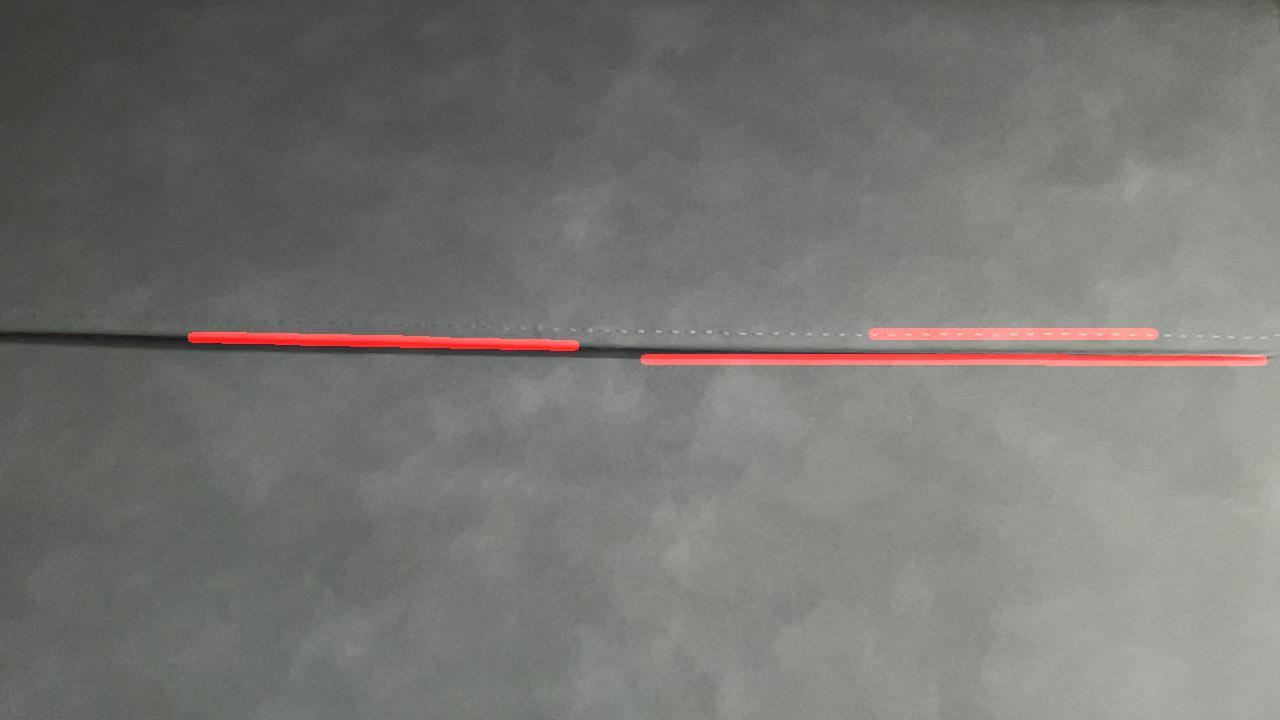

In [13]:
cap = cv2.VideoCapture(0)
cap.set(3,320)
cap.set(4,240)

d = Idisplay.display("Window", display_id=1)
d2 = Idisplay.display("Frame Rate", display_id=2)

for i in range(200):
    try:
        t1 = time.time()
        _, frame = cap.read()
        frame = cv2.flip(frame, 1)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        im = array_to_image(frame)
        t2 = time.time()
        s = f"{int(1 / (t2 - t1))} FPS"
        d.update(im)
        d2.update(Idisplay.HTML(s))
    except:
        pass

# 2. 윤곽선 추출
촬영되는 영상에서 윤곽선만을 추출합니다.

In [14]:
# 윤곽선 추출
# Canny 이미지 처리함수
def canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    canny = cv2.Canny(blur, 50, 150)
    return canny

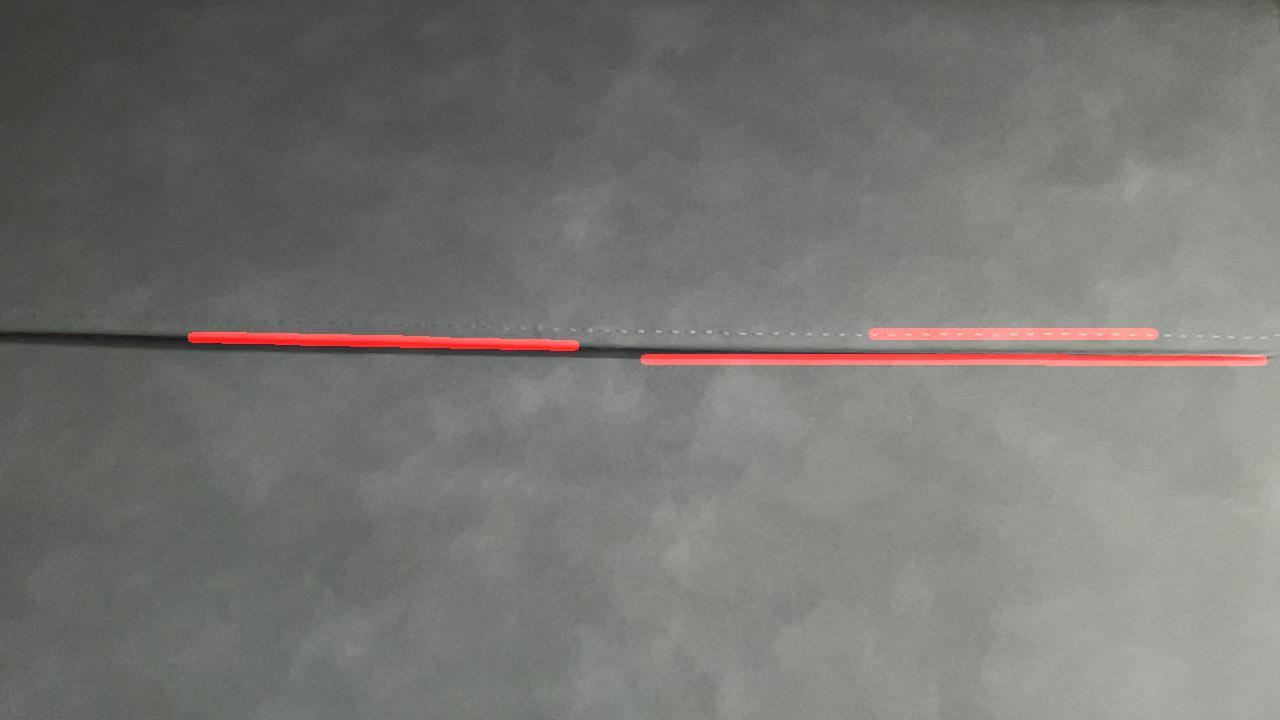

In [15]:
cap = cv2.VideoCapture(0)
cap.set(3,320)
cap.set(4,240)

d = Idisplay.display("Window", display_id=1)
d2 = Idisplay.display("Frame Rate", display_id=2)

for i in range(200):
    try:
        t1 = time.time()
        _, frame = cap.read()
        frame = cv2.flip(frame, 1)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = canny(frame)
        im = array_to_image(frame)
        t2 = time.time()
        s = f"{int(1 / (t2 - t1))} FPS"
        d.update(im)
        d2.update(Idisplay.HTML(s))
    except:
        pass

# 3. 직선 추출
추출된 윤곽선에서 직선만을 골라 원본 화면 위에 표시합니다.

In [49]:
def hough_transform(image):
    rho = 7              #Distance resolution of the accumulator in pixels.
    theta = np.pi/180    #Angle resolution of the accumulator in radians.
    threshold = 200       #Only lines that are greater than threshold will be returned. 41
    minLineLength = 200   #Line segments shorter than that are rejected. 25
    maxLineGap = 100     #Maximum allowed gap between points on the same line to link them 20
    
    return cv2.HoughLinesP(image, rho = rho, theta = theta, threshold = threshold,
                           minLineLength = minLineLength, maxLineGap = maxLineGap)

def t_display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return line_image

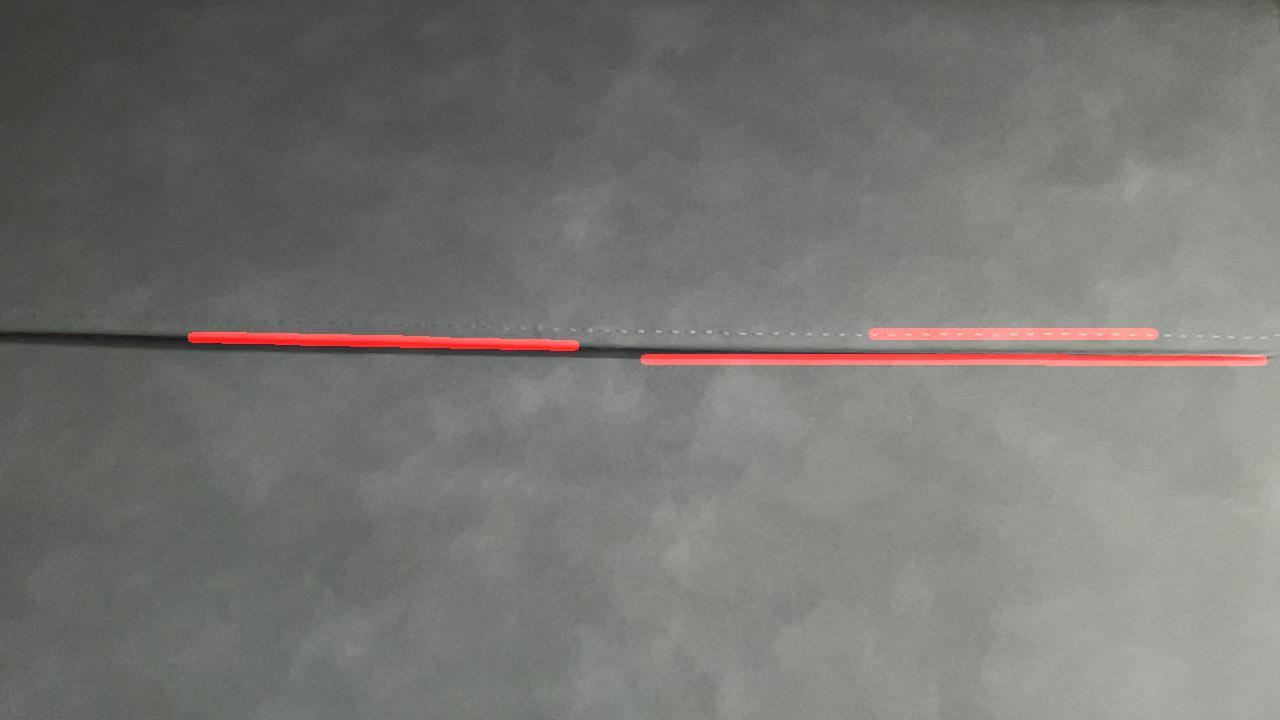

In [50]:
cap = cv2.VideoCapture(0)
cap.set(3,320)
cap.set(4,240)

d = Idisplay.display("Window", display_id=1)
d2 = Idisplay.display("Frame Rate", display_id=2)

for i in range(200):
    try:
        t1 = time.time()
        _, frame = cap.read()
        cframe = frame.copy()
        frame = cv2.flip(frame, 1)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        cannyframe = canny(frame)
#         lines = cv2.HoughLinesP(cannyframe, 1, np.pi/180, minLineLength=10, maxLindGap=10)
        lines = hough_transform(cannyframe)
        frame_lines = t_display_lines(frame, lines)
        combo_image = cv2.addWeighted(frame, 0.8, frame_lines, 1, 1)
        
        im = array_to_image(combo_image)
        t2 = time.time()
        s = f"{int(1 / (t2 - t1))} FPS"
        d.update(im)
        d2.update(Idisplay.HTML(s))
    except:
        pass

# 4. ROI(Region Of Interest) 설정
전체 영상 화면 중 가운데 가로선 부분에 대해서만 직선을 추출하도록 영역을 지정합니다.

In [24]:
def region_of_interest(image):
    mask = np.zeros_like(image)
    if len(image.shape) > 2:
        channel_count = image.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    rows, cols = image.shape[:2]
    
    bottom_left  = [cols * 0, rows * 0.3]
    top_left     = [cols * 0, rows * 0.7]
    bottom_right = [cols * 1, rows * 0.3]
    top_right    = [cols * 1, rows * 0.7]
    
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

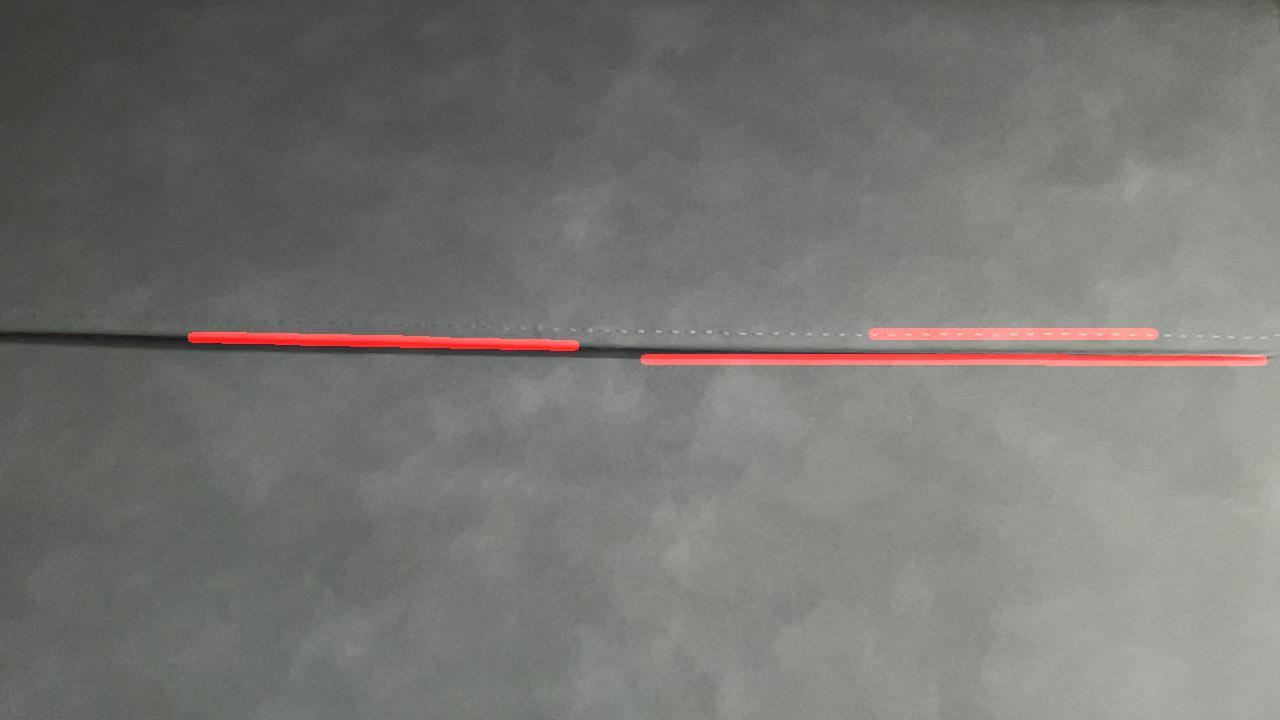

In [53]:
cap = cv2.VideoCapture(0)
cap.set(3,320)
cap.set(4,240)

d = Idisplay.display("Window", display_id=1)
d2 = Idisplay.display("Frame Rate", display_id=2)

for i in range(200):
    try:
        t1 = time.time()
        _, frame = cap.read()
        cframe = frame.copy()
        frame = cv2.flip(frame, 1)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        cannyframe = canny(frame)
        cropframe = region_of_interest(cannyframe)
        lines = hough_transform(cropframe)
        frame_lines = t_display_lines(frame, lines)
        combo_image = cv2.addWeighted(frame, 0.8, frame_lines, 1, 1)
        
        im = array_to_image(combo_image)
        t2 = time.time()
        s = f"{int(1 / (t2 - t1))} FPS"
        d.update(im)
        d2.update(Idisplay.HTML(s))
    except:
        pass